In [1]:
%matplotlib inline

Building spatial neighbors graph
================================

This example shows how to compute a spatial neighbors graph.

Spatial graph is a graph of spatial neighbors with observations as nodes
and neighbor-hood relations between observations as edges. We use
spatial coordinates of spots/cells to identify neighbors among them.
Different approach of defining a neighborhood relation among
observations are used for different types of spatial datasets.


In [88]:
import squidpy as sq

import numpy as np

import matplotlib.pyplot as plt

## Grid dataset e.g. VISIUM

First, we show how to compute the spatial neighbors graph for a Visium
dataset.


In [103]:
adata = sq.datasets.visium_fluo_adata()
adata

AnnData object with n_obs × n_vars = 2800 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

We use `squidpy.gr.spatial_neighbors` for this. The function expects
`coord_type = 'grid'` by default. We set this parameter here
explicitly for clarity. `n_rings` should be used only for Visium
datasets. It specifies for each spot how many hexagonal rings of spots
around will be considered neighbors.


> A short visualisation of the 'mapping' coordinates

(5169.1, 18322.9, 1472.9499999999998, 21692.05)

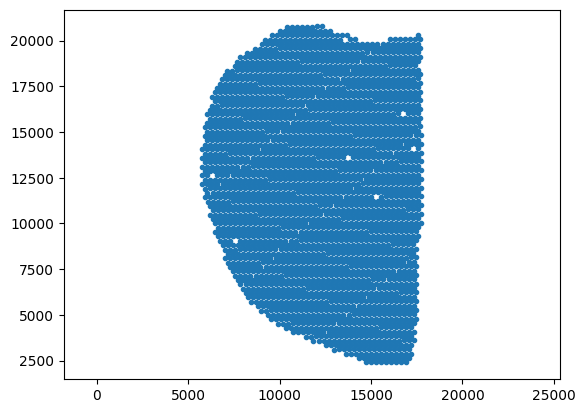

In [105]:
x = adata.obsm['spatial'][:, 0]
y = adata.obsm['spatial'][:, 1]

plt.scatter(x, y, marker='.')
plt.axis('equal')

In [3]:
sq.gr.spatial_neighbors(adata, n_rings=2, coord_type="grid", n_neighs=6)

The function builds a spatial graph and saves its adjacency matrix to
`adata.obsp['spatial_connectivities']` and weighted adjacency matrix to
`adata.obsp['spatial_distances']` by default. Note that it can also
build a a graph from a square grid, just set `n_neighs = 4`.


In [4]:
adata.obsp['spatial_connectivities']

<2800x2800 sparse matrix of type '<class 'numpy.float64'>'
	with 48240 stored elements in Compressed Sparse Row format>

In [5]:
adj_matr = adata.obsp['spatial_connectivities'].toarray()
np.argwhere(adj_matr>0)

array([[   0,  301],
       [   0,  357],
       [   0,  427],
       ...,
       [2799, 2385],
       [2799, 2413],
       [2799, 2627]])

In [6]:
len(np.argwhere(adj_matr>0))

48240

In [7]:
np.unique(adj_matr)

array([0., 1.])

In [8]:
len(np.unique(adj_matr))

2

> IDF: 48240 connections. If symmetric, then there are ((48240 - $diagonal) / 2) + $diagonal
> Lets see the weighted adjacency matrix...

The weights of the weighted adjacency matrix are ordinal numbers of
hexagonal rings in the case of `coord_type = 'visium'`.


In [9]:
adata.obsp['spatial_distances']

<2800x2800 sparse matrix of type '<class 'numpy.float64'>'
	with 48240 stored elements in Compressed Sparse Row format>

In [10]:
weighted_adj_matr = adata.obsp['spatial_distances'].toarray()
np.argwhere(weighted_adj_matr>0)

array([[   0,  301],
       [   0,  357],
       [   0,  427],
       ...,
       [2799, 2385],
       [2799, 2413],
       [2799, 2627]])

In [11]:
len(np.argwhere(weighted_adj_matr>0))

48240

In [12]:
np.unique(weighted_adj_matr)

array([0., 1., 2.])

In [13]:
len(np.unique(weighted_adj_matr))

3

In [14]:
comparison = adj_matr == weighted_adj_matr
len(np.argwhere(comparison == False))

31912

In [15]:
np.argwhere(comparison == False)

array([[   0,  427],
       [   0,  513],
       [   0,  678],
       ...,
       [2799, 1586],
       [2799, 2385],
       [2799, 2413]])

In [16]:
adj_matr[0, 513]

1.0

In [17]:
weighted_adj_matr[0, 513]

2.0

In [18]:
adj_matr[0, 427]

1.0

In [19]:
weighted_adj_matr[0, 427]

2.0

> IDF: adjacency matrix includes values [0,1], connected or not connected
> Weighted adjacency matrix includes values [0, 1, 2] directionality?

We can visualize the neighbors of a point to better visualize what
[n\_rings]{.title-ref} mean:


In [54]:
adata.obsp['spatial_connectivities'][420, :].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 599,  665, 1960,  814,  838, 1760,  503, 1606, 2701,  466, 2053,
        2486, 2228, 2074, 1801, 1414,  847,  152], dtype=int32))

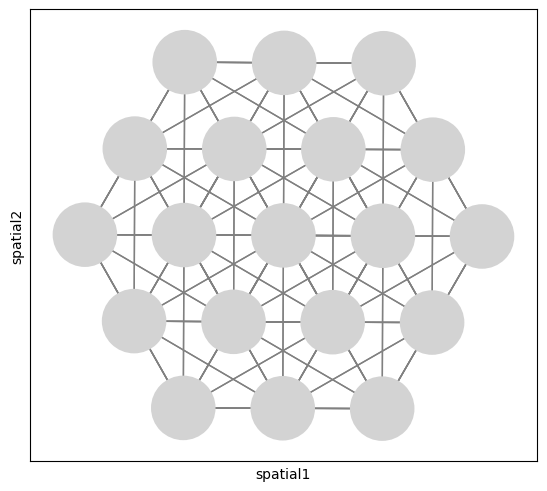

In [56]:
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(adata[idx, :], connectivity_key="spatial_connectivities", img=False, na_color="lightgrey")

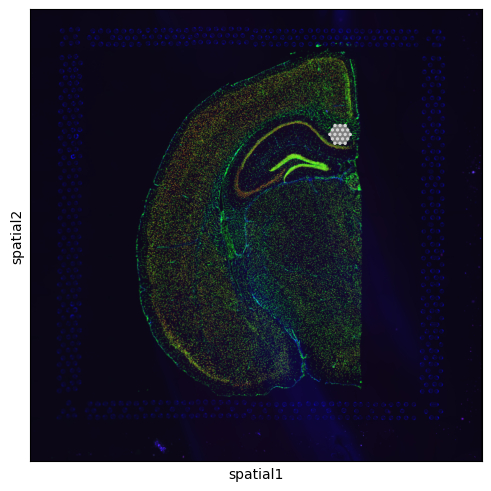

In [57]:
sq.pl.spatial_scatter(adata[idx, :], connectivity_key="spatial_connectivities", img=True, na_color="lightgrey")

> IDF: This serves to visualize the connectivity graph of a single node/area within the picture and its respective connections. The chosen node/area is arbitrary

## Non-grid dataset e.g. Imaging Mass Cytometry

Next, we show how to compute the spatial neighbors graph for a non-grid
dataset.


In [187]:
adata = sq.datasets.imc()
adata

AnnData object with n_obs × n_vars = 4668 × 34
    obs: 'cell type'
    uns: 'cell type_colors'
    obsm: 'spatial'

(-35.75575447570333, 767.6943734015346, -38.248297213622294, 827.5300309597523)

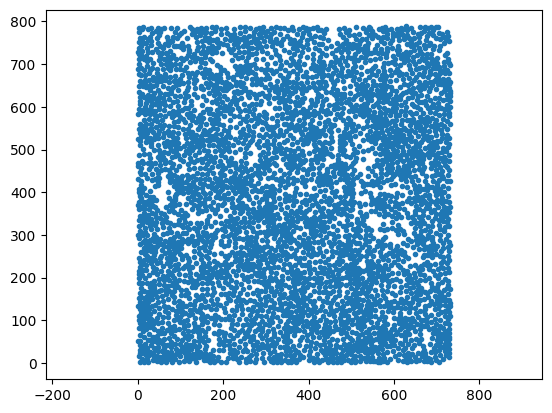

In [122]:
x = adata.obsm['spatial'][:, 0]
y = adata.obsm['spatial'][:, 1]

plt.scatter(x, y, marker='.')
plt.axis('equal')

We use the same function for this with `coord_type = 'generic'`.
`n_neighs` and `radius` can be used for non-Visium datasets. `n_neighs`
specifies a fixed number of the closest spots for each spot as
neighbors. Alternatively, `delaunay = True` can be used, for a Delaunay
triangulation graph.


In [188]:
sq.gr.spatial_neighbors(adata, n_neighs=10, coord_type="generic")

In [124]:
len(adata.obsp['spatial_connectivities'].nonzero()[0])

46680

> All nodes have non-zero edges

/home/ifichtner/anaconda3/envs/squidpy/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ifichtner/anaconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


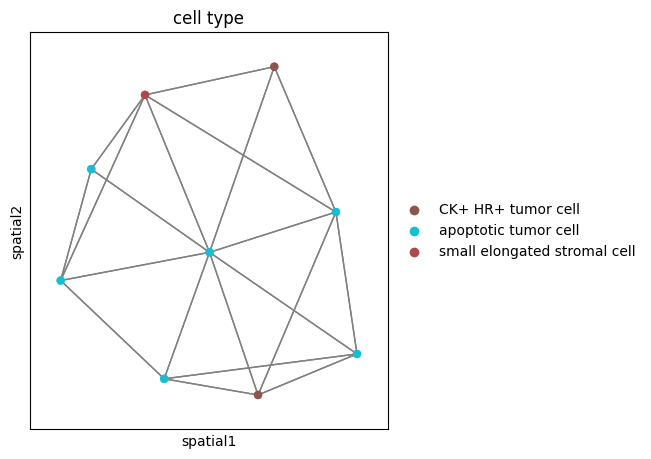

In [141]:
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(adata[idx, :], shape=None, color="cell type", connectivity_key="spatial_connectivities", size=100)

We use the same function for this with `coord_type = 'generic'` and
`delaunay = True`. You can appreciate that the neighbor graph is
slightly different than before.


/home/ifichtner/anaconda3/envs/squidpy/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ifichtner/anaconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


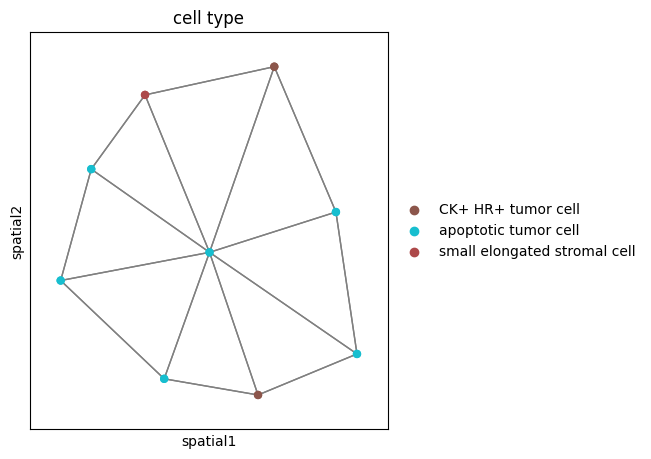

In [180]:
sq.gr.spatial_neighbors(adata, delaunay=True, coord_type="generic")
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata[idx, :],
    shape=None,
    color="cell type",
    connectivity_key="spatial_connectivities",
    size=100,
)

In order to get all spots within a specified radius (in units of the
spatial coordinates) from each spot as neighbors, the parameter `radius`
should be used.


In [192]:
sq.gr.spatial_neighbors(adata, radius=15, coord_type="generic")

adata.obsp["spatial_connectivities"]
adata.obsp["spatial_distances"]

<4668x4668 sparse matrix of type '<class 'numpy.float64'>'
	with 24054 stored elements in Compressed Sparse Row format>

In [190]:
(adata.obsp['spatial_connectivities'].toarray() == 0).all()

#sq.gr.spatial_scatter(adata[idx, :]¸ 
#                      shape='None', 
#                      color='cell type', 
#                      connectivity_key='spatial_connectivities', 
#                      size = 100)

False

/home/ifichtner/anaconda3/envs/squidpy/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ifichtner/anaconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


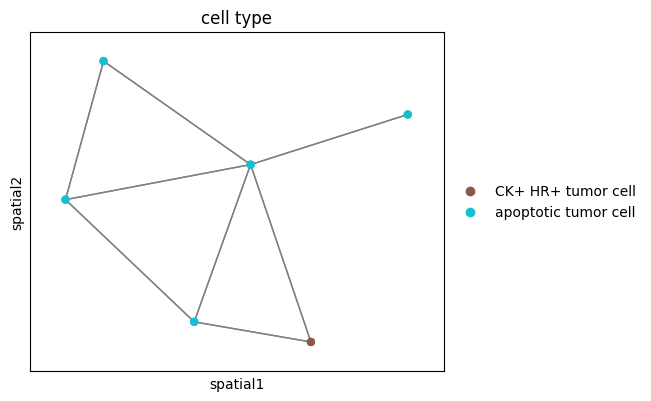

In [193]:
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(adata[idx, :], shape=None, color="cell type", connectivity_key="spatial_connectivities", size=100)